In [1]:
import pandas as pd
import geopandas as gpd
import uuid
import matplotlib.pyplot as plt
import re
from math import ceil
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from shapely import wkt
import os
import ast
from osgeo import gdal
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.plot import show
import xml.etree.ElementTree as ET
import re

In [2]:
# Load the raster legend CSV
legend_path = 'cavm_raster/raster_cavm_legend.csv'
legend_df = pd.read_csv(legend_path)

In [3]:
# Path to your QML file
qml_file = 'cavm_raster/cavm_colors.qml'

# Parse the XML
tree = ET.parse(qml_file)
root = tree.getroot()

# Locate the color palette entries
palette_entries = []
for palette_entry in root.findall(".//colorPalette/paletteEntry"):
    value = palette_entry.get('value')
    color = palette_entry.get('color')
    alpha = palette_entry.get('alpha')
    label = palette_entry.get('label')
    
    # Remove the " -- text" part from the label
    cleaned_label = re.sub(r' -.*', '', label)
    
    palette_entries.append({
        'value': value,
        'color': color,
        'alpha': alpha,
        'label': cleaned_label
    })

# Display the cleaned data
for entry in palette_entries:
    print(f"Value: {entry['value']}, Color: {entry['color']}, Alpha: {entry['alpha']}, Label: {entry['label']}")

Value: 1, Color: #d7d7b3, Alpha: 178, Label: B1
Value: 2, Color: #a8a802, Alpha: 178, Label: B2a
Value: 3, Color: #a68282, Alpha: 178, Label: B3
Value: 4, Color: #8282a0, Alpha: 178, Label: B4
Value: 5, Color: #cdcd66, Alpha: 178, Label: B2b
Value: 21, Color: #ffebaf, Alpha: 178, Label: G1
Value: 22, Color: #ffd37f, Alpha: 178, Label: G2
Value: 23, Color: #e6e600, Alpha: 178, Label: G3
Value: 24, Color: #ffff00, Alpha: 178, Label: G4
Value: 31, Color: #dfb0b0, Alpha: 178, Label: P1
Value: 32, Color: #db949e, Alpha: 178, Label: P2
Value: 33, Color: #97e602, Alpha: 178, Label: S1
Value: 34, Color: #38a802, Alpha: 178, Label: S2
Value: 41, Color: #9eedbd, Alpha: 178, Label: W1
Value: 42, Color: #73ffdf, Alpha: 178, Label: W2
Value: 43, Color: #04e6a9, Alpha: 178, Label: W3
Value: 91, Color: #0070ff, Alpha: 178, Label: FW
Value: 92, Color: #e0f2ff, Alpha: 178, Label: SW
Value: 93, Color: #ffffff, Alpha: 178, Label: GL
Value: 99, Color: #cccccc, Alpha: 178, Label: NA


# Count plot overlap with CAVM zones

In [4]:
si = pd.read_csv('../survey_unit_information.csv', index_col=0)
si.groupby(['data_source', 'cavm_unit'])['cavm_unit'].count()

data_source  cavm_unit
ABR          FW            12
             G3            10
             G4            57
             S1            11
             W2            17
AKVEG        B1             4
             FW            10
             G3            17
             G4            65
             P1             2
             S1            18
             SW             9
             W1             3
             W2            53
             W3             4
AVA          B1            29
             G3           163
             G4            58
             W2            58
NEON         FW             6
             G3           203
             S1            18
             W1            53
NGA          G4            27
             S1            61
             S2             6
             W3             4
Name: cavm_unit, dtype: int64

In [5]:
# read fcover data for each PFT
fcover = pd.read_csv('../synthesized_pft_fcover.csv', index_col=0)

In [6]:
fcover_w_area = fcover.merge(si[['plot_area', 'data_source']], left_index=True, right_index=True, how='left')

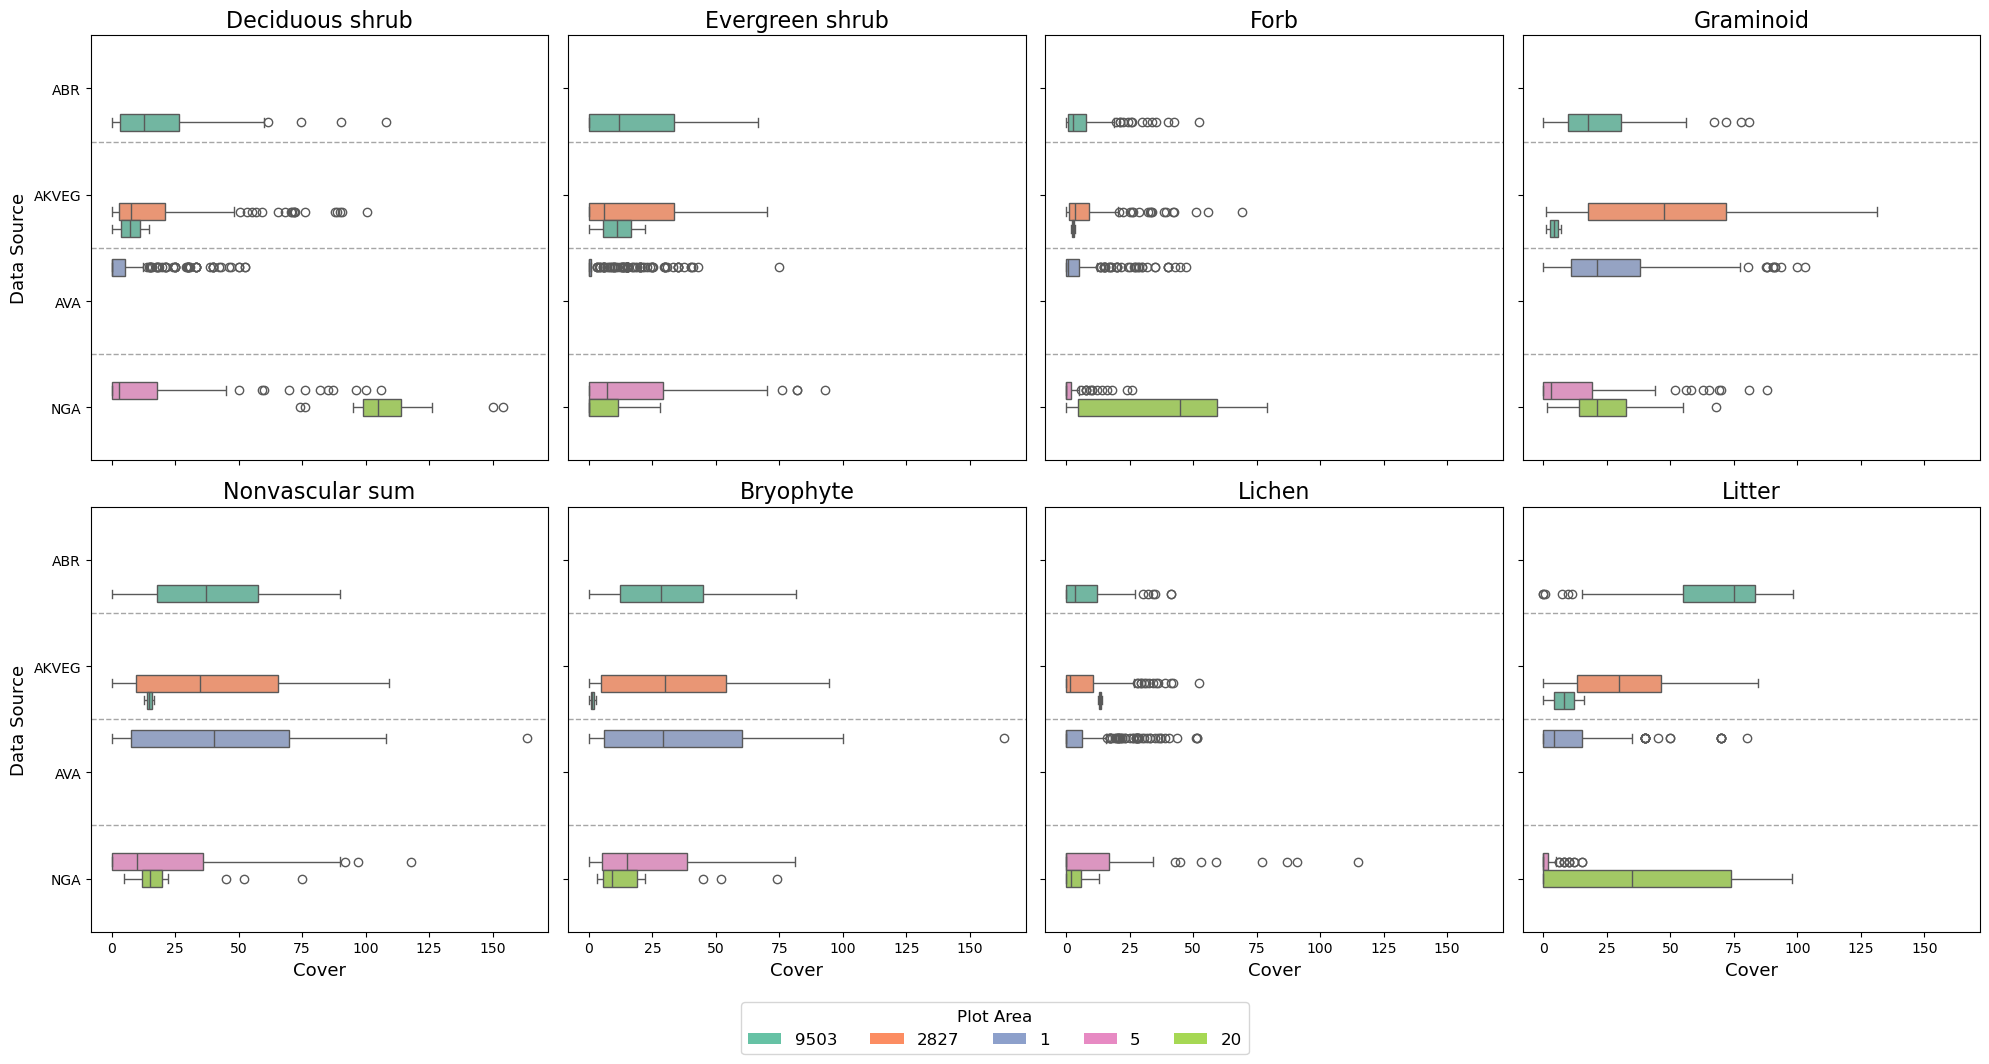

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pandas as pd
from matplotlib.patches import Patch

# Exclude cover columns for evergreen_tree and deciduous_tree
cover_columns = [col for col in fcover_w_area.columns 
                 if '_cover' in col 
                 and 'evergreen_tree' not in col 
                 and 'deciduous_tree' not in col
                 and 'other' not in col
                 and 'water' not in col
                 and 'bareground' not in col]

# Determine the layout: 4 subplots per row
num_plots = len(cover_columns)
ncols = 4
nrows = math.ceil(num_plots / ncols)

# Create a custom palette: one distinct color for each unique plot_area,
# filtering out NaN values.
unique_plot_areas = fcover_w_area['plot_area'].dropna().unique()
palette = sns.color_palette("Set2", n_colors=len(unique_plot_areas))
palette_dict = dict(zip(unique_plot_areas, palette))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                         figsize=(ncols * 5, nrows * 5), 
                         squeeze=False, sharex=True, sharey=True)

# Loop over each cover column and create a boxplot with:
# x-axis: cover values, y-axis: data_source, hue: plot_area.
for idx, cover in enumerate(cover_columns):
    row = idx // ncols
    col = idx % ncols
    ax = axes[row, col]
    
    sns.boxplot(data=fcover_w_area, 
                x=cover, 
                y='data_source', 
                hue='plot_area', 
                palette=palette_dict, 
                dodge=True, 
                ax=ax)
    
    # Draw horizontal reference lines
    ax.axhline(0.5, color='grey', linestyle='--', alpha=0.7, linewidth=1)
    ax.axhline(1.5, color='grey', linestyle='--', alpha=0.7, linewidth=1)
    ax.axhline(2.5, color='grey', linestyle='--', alpha=0.7, linewidth=1)

    # Format title using the cover column name
    pft = cover.split('_cover')[0].replace('_', ' ')
    ax.set_title(pft.capitalize(), fontsize=16)
    ax.set_xlabel('Cover', fontsize=13)
    ax.set_ylabel('Data Source', fontsize=13)
    
    # Remove the subplot legend (we'll add one figure-level legend later)
    if ax.get_legend() is not None:
        ax.get_legend().remove()

# Create a single legend for the entire figure.
# Build legend handles using matplotlib.patches.Patch so we can customize labels.
legend_handles = []
for area in unique_plot_areas:
    try:
        # Attempt to convert the plot_area value to float and format it
        label = f"{float(area):.0f}"
    except ValueError:
        label = str(area)
    patch = Patch(facecolor=palette_dict[area], label=label)
    legend_handles.append(patch)

# Place the legend below the subplots.
# ncol is set to the number of unique plot areas (i.e. one column per legend item).
fig.legend(handles=legend_handles, title='Plot Area', title_fontsize=12,
           loc='upper center', bbox_to_anchor=(0.5, 0),
           ncol=len(legend_handles), fontsize=12)

# Adjust layout to leave space for the figure-level legend
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [8]:
fcover_w_area['plot_area'].unique()

array([9.50331778e+03, 2.82743339e+03, 1.00000000e+00,            nan,
       4.90873852e+00, 1.96349541e+01])

In [9]:
import pandas as pd
from scipy.stats import pearsonr

# Identify columns that contain '_cover'
cover_columns = [col for col in fcover_w_area.columns if '_cover' in col]

results = {}

for cover in cover_columns:
    # Select the two columns and drop any missing values
    subset = fcover_w_area[['plot_area', cover]].dropna()
    
    # Calculate the Pearson correlation and p-value
    corr, p_value = pearsonr(subset['plot_area'], subset[cover])
    
    results[cover] = {'correlation': corr, 'p_value': p_value}

# Print the results for each PFT
for cover, stats in results.items():
    significance = "significant" if stats['p_value'] < 0.05 else "not significant"
    print(f"{cover}: Pearson correlation = {stats['correlation']:.2f}, p-value = {stats['p_value']:.4f} ({significance})")

deciduous_shrub_cover: Pearson correlation = 0.10, p-value = 0.0067 (significant)
deciduous_tree_cover: Pearson correlation = nan, p-value = nan (not significant)
evergreen_shrub_cover: Pearson correlation = 0.23, p-value = 0.0000 (significant)
evergreen_tree_cover: Pearson correlation = -0.02, p-value = 0.5107 (not significant)
forb_cover: Pearson correlation = 0.06, p-value = 0.1006 (not significant)
graminoid_cover: Pearson correlation = -0.01, p-value = 0.7782 (not significant)
nonvascular_sum_cover: Pearson correlation = -0.00, p-value = 0.9829 (not significant)
bryophyte_cover: Pearson correlation = -0.04, p-value = 0.2666 (not significant)
lichen_cover: Pearson correlation = 0.02, p-value = 0.6435 (not significant)
litter_cover: Pearson correlation = 0.72, p-value = 0.0000 (significant)
other_cover: Pearson correlation = 0.03, p-value = 0.3857 (not significant)
water_cover: Pearson correlation = -0.14, p-value = 0.0002 (significant)
bareground_cover: Pearson correlation = 0.19, 

/tmp/ipykernel_66132/1375230575.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(subset['plot_area'], subset[cover])


In [10]:
import pandas as pd
from scipy.stats import spearmanr

# Identify columns that contain '_cover'
cover_columns = [col for col in fcover_w_area.columns if '_cover' in col]

results = {}

for cover in cover_columns:
    # Select the two columns and drop any missing values
    subset = fcover_w_area[['plot_area', cover]].dropna()
    
    # Calculate the Spearman correlation and p-value
    corr, p_value = spearmanr(subset['plot_area'], subset[cover])
    
    results[cover] = {'spearman_correlation': corr, 'p_value': p_value}

# Print the results for each PFT
for cover, stats in results.items():
    significance = "significant" if stats['p_value'] < 0.05 else "not significant"
    print(f"{cover}: Spearman correlation = {stats['spearman_correlation']:.2f}, p-value = {stats['p_value']:.4f} ({significance})")

deciduous_shrub_cover: Spearman correlation = 0.43, p-value = 0.0000 (significant)
deciduous_tree_cover: Spearman correlation = nan, p-value = nan (not significant)
evergreen_shrub_cover: Spearman correlation = 0.41, p-value = 0.0000 (significant)
evergreen_tree_cover: Spearman correlation = 0.01, p-value = 0.7948 (not significant)
forb_cover: Spearman correlation = 0.27, p-value = 0.0000 (significant)
graminoid_cover: Spearman correlation = 0.07, p-value = 0.0747 (not significant)
nonvascular_sum_cover: Spearman correlation = -0.03, p-value = 0.4202 (not significant)
bryophyte_cover: Spearman correlation = -0.04, p-value = 0.2404 (not significant)
lichen_cover: Spearman correlation = 0.12, p-value = 0.0017 (significant)
litter_cover: Spearman correlation = 0.61, p-value = 0.0000 (significant)
other_cover: Spearman correlation = 0.18, p-value = 0.0000 (significant)
water_cover: Spearman correlation = -0.00, p-value = 0.9093 (not significant)
bareground_cover: Spearman correlation = 0.1

/tmp/ipykernel_66132/1509577434.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = spearmanr(subset['plot_area'], subset[cover])


In [17]:
cols = ['survey_year', 'plot_area', 'plot_shape', 'data_source', 'survey_method', 'fcover_scale', 'cavm_unit']
feats = si[cols]
feats = feats.astype(str)
fcover_and_feats = fcover.merge(feats, left_index=True, right_index=True, how='left')
fcover_and_feats = fcover_and_feats.dropna(how='any')

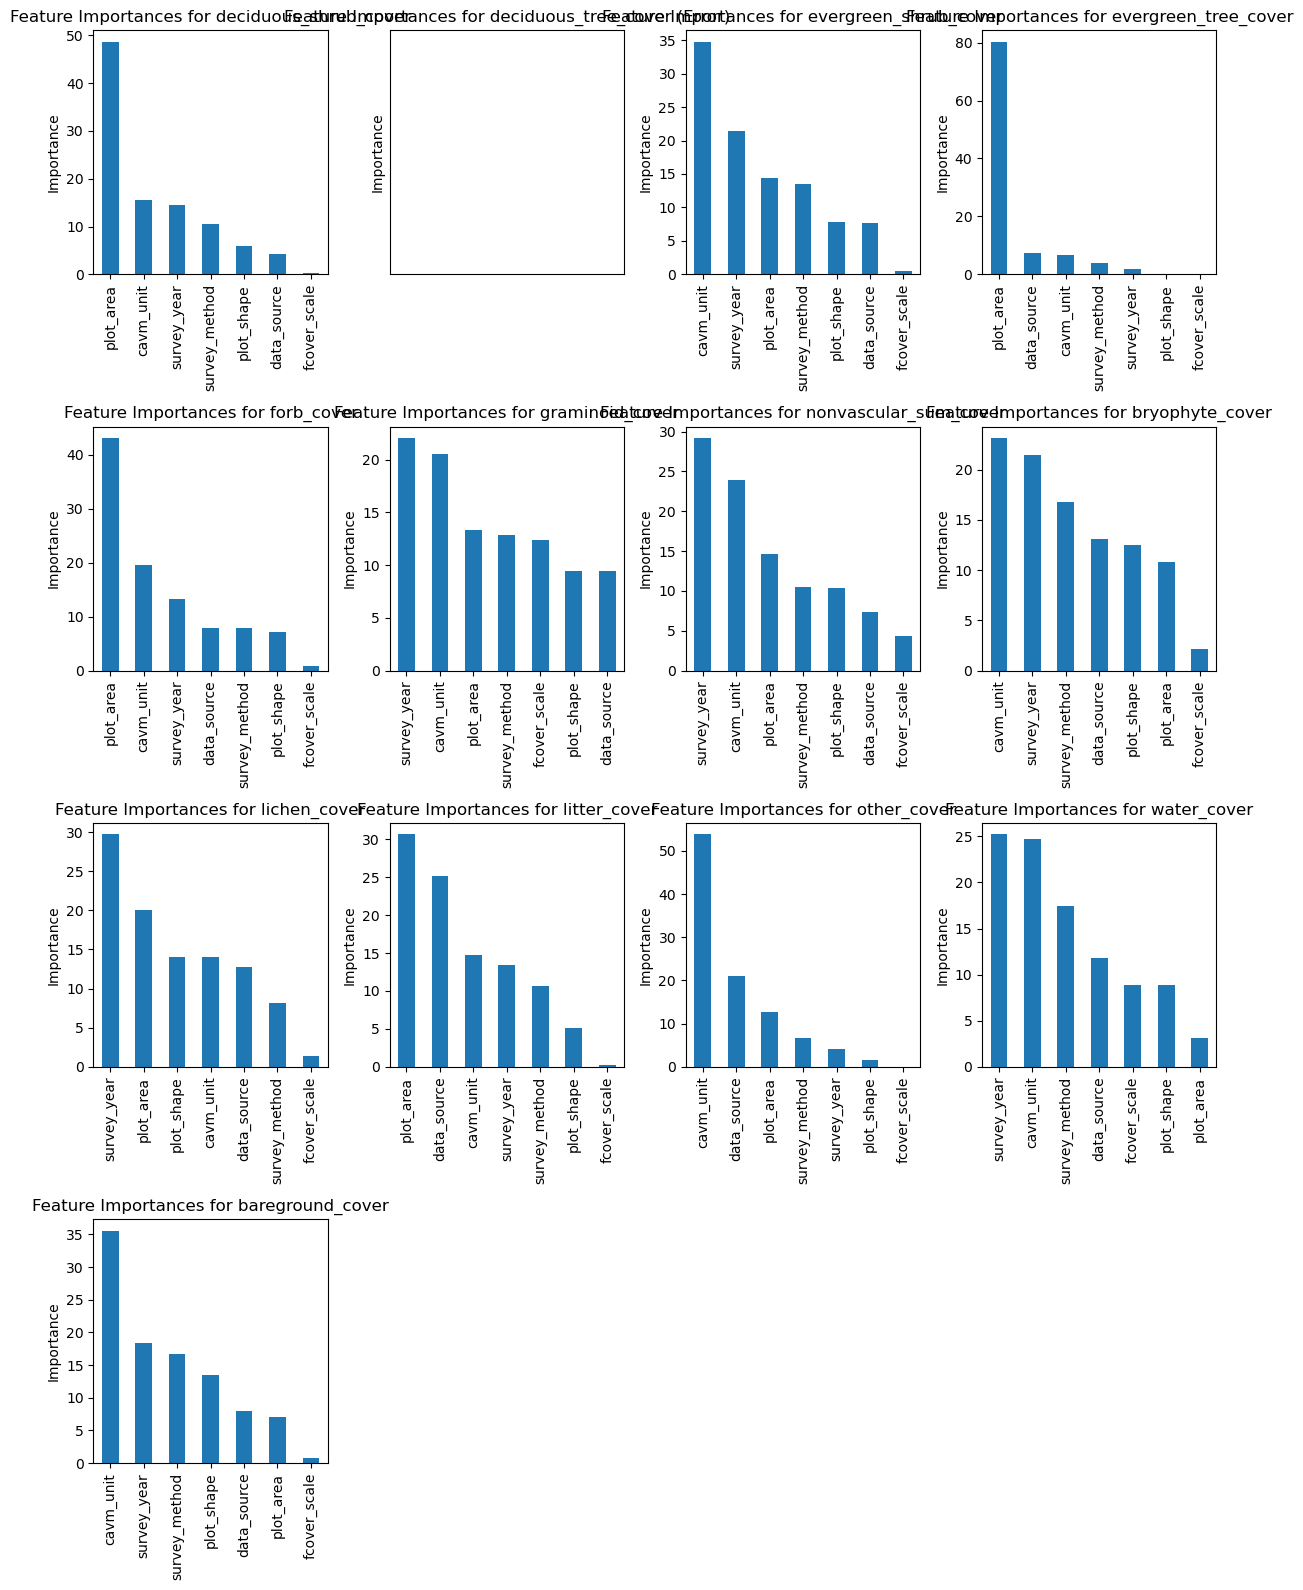

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import math

# Prepare your data: drop rows with missing target values.
cover_cols = [col for col in fcover_and_feats.columns if col.endswith('_cover')]

# Define number of subplots
num_plots = len(cover_cols)
ncols = 4  # Set your desired number of columns
nrows = math.ceil(num_plots / ncols)  # Calculate number of rows needed

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))
axes = axes.flatten()  # Flatten in case of multiple subplots

for ax, cover_col in zip(axes, cover_cols):
    data = fcover_and_feats.dropna(subset=[cover_col]).copy()

    try:
        # Define predictors and target (all columns except 'plot_area')
        predictor_cols = cols
        X = data[predictor_cols]
        y = data[cover_col]

        # Optionally, split the data into training and testing sets.
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

        # Initialize the CatBoostRegressor.
        model = CatBoostRegressor(
            iterations=200,
            learning_rate=0.1,
            depth=6,
            cat_features=cols,
            verbose=0  # Suppress training output
        )
        model.fit(X_train, y_train)

        # Get feature importances
        importances = model.get_feature_importance()
        feature_importance = pd.Series(importances, index=predictor_cols).sort_values(ascending=False)

        # Plot the feature importances
        feature_importance.plot(kind="bar", ax=ax)
        ax.set_title(f"Feature Importances for {cover_col}")
        ax.set_ylabel("Importance")
    except Exception as e:
        ax.set_title(f"Feature Importances for {cover_col} (Error)")
        ax.set_ylabel("Importance")
        ax.set_xticks([])
        ax.set_yticks([])

# Hide any unused subplots if the number of plots is less than nrows * ncols
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# PAVC Gridded (masked only) and CAVM overlap

{'1': 'B1', '2': 'B2a', '3': 'B3', '4': 'B4', '5': 'B2b', '21': 'G1', '22': 'G2', '23': 'G3', '24': 'G4', '31': 'P1', '32': 'P2', '33': 'S1', '34': 'S2', '41': 'W1', '42': 'W2', '43': 'W3', '91': 'FW', '92': 'SW', '93': 'GL', '99': 'NA'}


/tmp/ipykernel_446626/1278324243.py:232: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


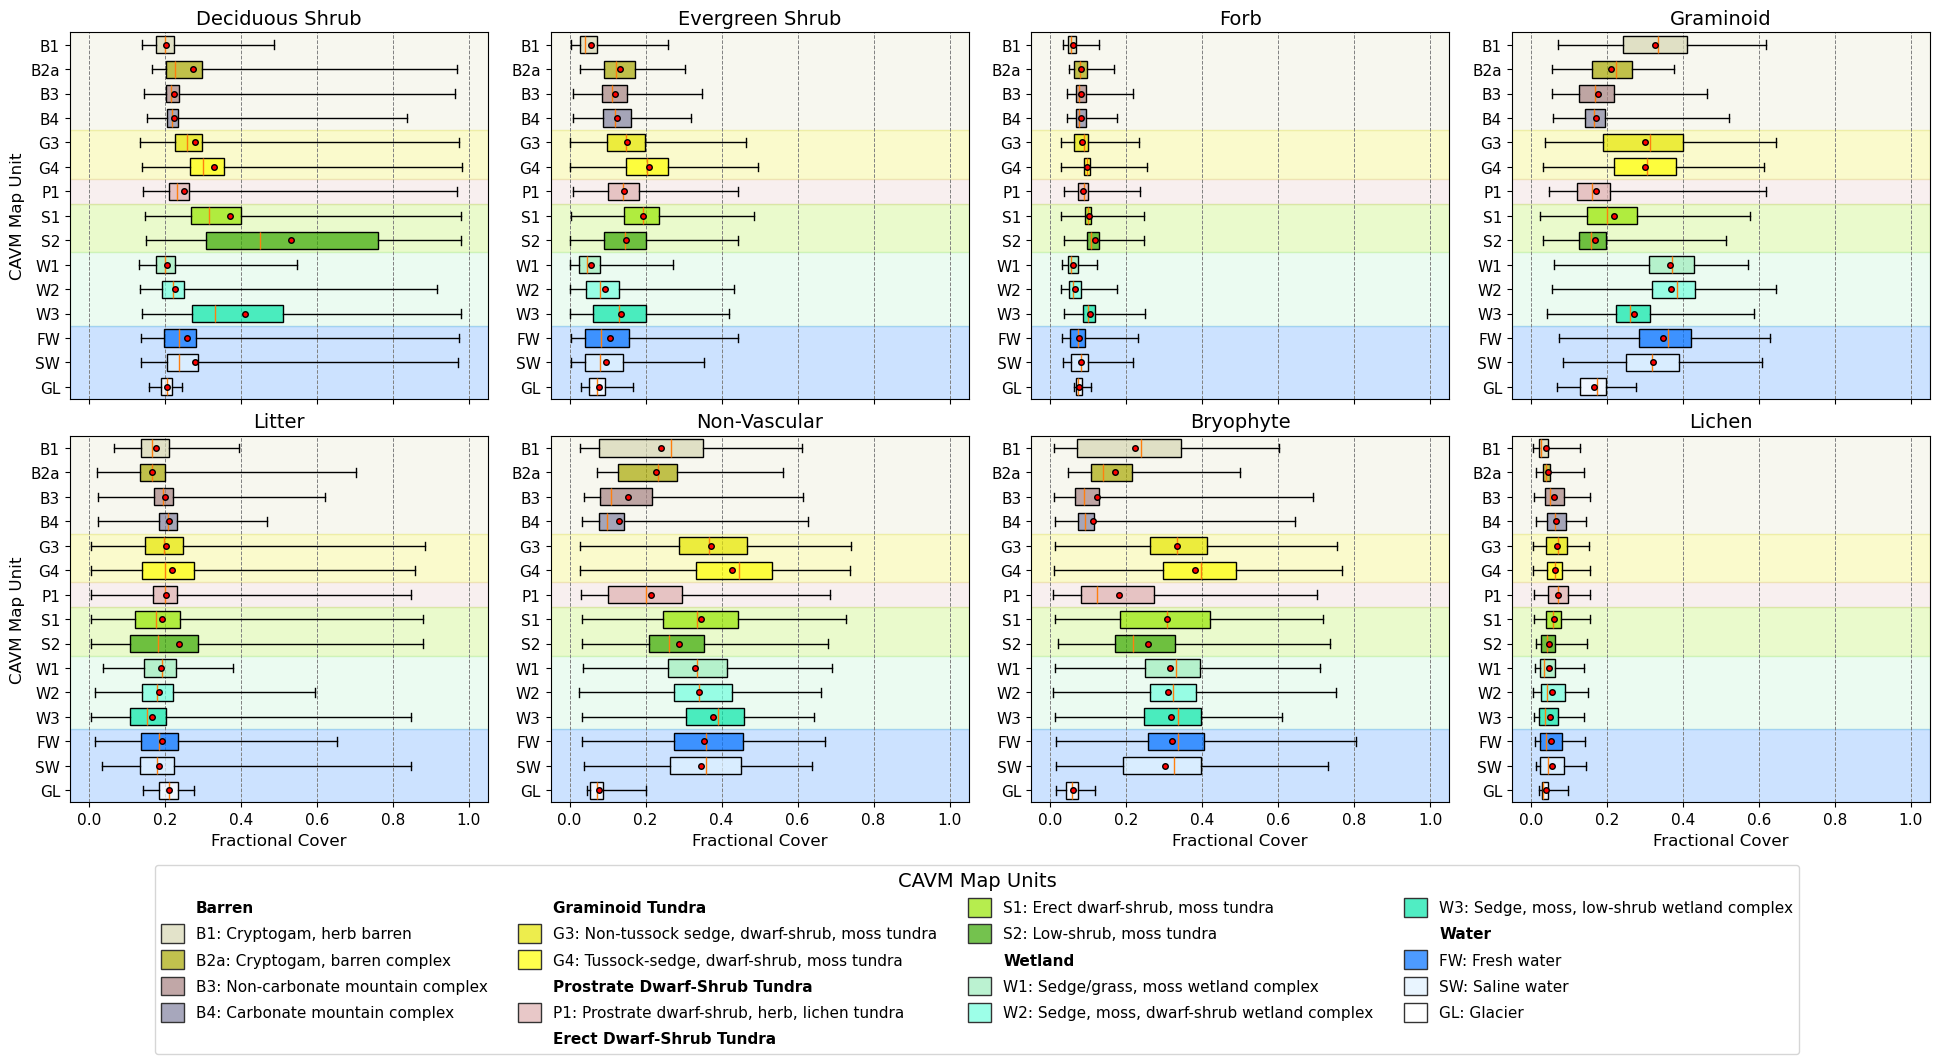

In [14]:
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# Define file paths for each plant functional type (PFT)
pft_files = {
    'deciduous_shrub_cover': "zonal_stats_20250303/deciduous_shrub_masked.txt",
    'evergreen_shrub_cover': "zonal_stats_20250303/evergreen_shrub_masked.txt",
    'forb_cover': "zonal_stats_20250303/forb_masked.txt",
    'graminoid_cover': "zonal_stats_20250303/graminoid_masked.txt",
    'litter_cover': "zonal_stats_20250303/litter_masked.txt",
    'lichen_cover': "zonal_stats_20250303/lichen_masked.txt",
    'bryophyte_cover': "zonal_stats_20250303/bryophyte_masked.txt",
    'non-vascular_cover': "zonal_stats_20250303/non-vascular_masked.txt"
}

# Create mapping of zone numbers to CAVM unit names
zone_to_cavm = {entry['value']: entry['label'] for entry in palette_entries}
print(zone_to_cavm)

# Ensure we work with a copy of legend_df to avoid modifying the original
legend_df_copy = legend_df[['Vegetation Unit', 'Short Description']].drop_duplicates().copy()

# Identify all possible zones across all datasets
all_zones = set()

# First pass: Collect all unique zones
for file_path in pft_files.values():
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, usecols=['zone'])
        all_zones.update(df['zone'].astype(str).dropna().unique())

all_zones = sorted(all_zones)  # Sort for consistent ordering

# Define the desired subplot order
plot_order = [
    'deciduous_shrub_cover', 'evergreen_shrub_cover', 'forb_cover', 'graminoid_cover',
    'litter_cover', 'non-vascular_cover', 'bryophyte_cover', 'lichen_cover'
]

# Second pass: Process each dataset and ensure all zones are included
precomputed_boxplot_data = {}
for cover_type, file_path in pft_files.items():
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)

        # Drop NaN values and ensure necessary columns exist
        df = df[['zone', 'min', 'first_quart', 'median', 'third_quart', 'max', 'mean']]

        # Convert 'zone' to string and map to CAVM unit names
        df['zone'] = df['zone'].astype(str)
        df['CAVM Unit'] = df['zone'].map(zone_to_cavm)

        # Ensure all zones are present, filling missing ones with NaN
        df = df.set_index('zone').reindex(all_zones).reset_index()

        # Map CAVM Unit again after reindexing
        df['CAVM Unit'] = df['zone'].map(zone_to_cavm)
        df = df.dropna(subset=['CAVM Unit'])
        df = df[df['CAVM Unit'] != 'NA']  # Drop 'NA' CAVM Unit

        # Merge with legend_df_copy to add Short Description as cavm_unit_description
        df = df.merge(legend_df_copy, left_on='CAVM Unit', right_on='Vegetation Unit', how='left')
        df = df.rename(columns={'Short Description': 'cavm_unit_description'})

        df['Cover Type'] = cover_type  # Label with cover type
        precomputed_boxplot_data[cover_type] = df

# Identify zones where all datasets have only NaNs
all_dfs = [df.set_index('zone')[['min', 'first_quart', 'median', 'third_quart', 'max', 'mean']] for df in precomputed_boxplot_data.values()]
combined_df = pd.concat(all_dfs, axis=1, keys=precomputed_boxplot_data.keys())  # MultiIndex column structure
nan_only_zones = combined_df.isna().all(axis=1)  # Identify zones that are NaN across all datasets
zones_to_remove = nan_only_zones[nan_only_zones].index.tolist()  # Get list of zones to drop

# Remove those zones from all datasets
for cover_type in precomputed_boxplot_data:
    precomputed_boxplot_data[cover_type] = precomputed_boxplot_data[cover_type][~precomputed_boxplot_data[cover_type]['zone'].isin(zones_to_remove)]

# Define the color map from palette_entries
color_map = {entry['label']: (mcolors.hex2color(entry['color']) + (int(entry['alpha']) / 255,)) for entry in palette_entries}

# Define order of CAVM units based on the given mapping
cavm_order = [entry['label'] for entry in palette_entries]

# Ensure plots are arranged in the specified order
ordered_boxplot_data = {cover_type: precomputed_boxplot_data[cover_type] for cover_type in plot_order if cover_type in precomputed_boxplot_data}

# Set up the subplots
num_cols = 4
num_rows = 2  # Fixed to match the two-row layout
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(24, 10), sharex=True)
axes = axes.flatten()

# Create boxplots using precomputed stats
for i, (ax, cover_type) in enumerate(zip(axes, ordered_boxplot_data.keys())):
    
    data = ordered_boxplot_data[cover_type]
    title = cover_type.replace('_', ' ').replace(' cover', '').title()

    # Ensure category order for y-axis
    data['CAVM Unit'] = pd.Categorical(data['CAVM Unit'], categories=cavm_order, ordered=True)
    data = data.sort_values('CAVM Unit')

    # Prepare boxplot statistics
    bxp_stats = []
    y_labels = []
    for _, row in data.iterrows():
        y_labels.append(row['CAVM Unit'])
        bxp_stats.append({
            'med': row['median'],
            'q1': row['first_quart'],
            'q3': row['third_quart'],
            'whislo': row['min'],
            'whishi': row['max'],
            'mean': row['mean'],
            'fliers': []  # No outliers in dataset
        })

    # Plot boxplots using precomputed statistics (flipped orientation)
    artist = ax.bxp(bxp_stats,
                    vert=False,  # Flip the boxplots horizontally
                    showmeans=True,
                    meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'black', 'markersize':'4'},
                    patch_artist=True,
                    widths=0.7)

    # Color boxes based on the vegetation unit
    for patch, cavm_unit in zip(artist['boxes'], y_labels):
        patch.set_facecolor(color_map.get(cavm_unit, 'gray'))  # Default to gray if color not found

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Fractional Cover', fontsize=12)
    ax.set_yticklabels(y_labels)
    ax.set_xlim(-0.05,1.05)
    
    if i % num_cols == 0:
        ax.set_ylabel('CAVM Map Unit', fontsize=12)
    else:
        ax.set_ylabel('')
    
    ax.xaxis.grid(True, linestyle='--', linewidth=0.8, color='grey')
    ax.invert_yaxis()

    # Define shading regions
    fill_regions = [('B1', 'G3'),
                    ('G3', 'P1'),
                    ('P1', 'S1'),
                    ('S1', 'W1'),
                    ('W1', 'FW'),
                    ('FW', 'GL')]

    # Apply region shading
    for start_unit, end_unit in fill_regions:
        if start_unit in y_labels and end_unit in y_labels:
            start_index = y_labels.index(start_unit) + 0.5
            end_index = y_labels.index(end_unit) + 0.5
    
            # Ensure shading extends fully to the bottom of the graph
            if end_unit == y_labels[-1]:  
                end_index = len(y_labels) + 0.5  # Extend to the very bottom
    
            color = color_map[start_unit]
            ax.axhspan(
                ymin=end_index, ymax=start_index,
                color=color,
                alpha=0.2
            )

    # Only label bottom row subplots
    if i >= num_cols:
        ax.set_xlabel('Fractional Cover', fontsize=12)
    else:
        ax.set_xlabel('')

    ax.xaxis.grid(True, linestyle='--', linewidth=0.7, color='grey')
    ax.tick_params(axis='both', which='major', labelsize=11)

# Create the legend handles with adjusted column distribution
sections = {
    'Barren': ['B1', 'B2a', 'B3', 'B4'],
    'Graminoid Tundra': ['G3', 'G4'],
    'Prostrate Dwarf-Shrub Tundra': ['P1'],
    'Erect Dwarf-Shrub Tundra': ['S1', 'S2'],
    'Wetland': ['W1', 'W2', 'W3'],
    'Water': ['FW', 'SW', 'GL']
}

# Create legend handles and their corresponding labels
handles = []
for section, units in sections.items():
    handles.append(mpatches.Patch(facecolor='none', edgecolor='none', label=f'{section}'))
    
    for unit in units:
        unit_description = legend_df_copy.loc[legend_df_copy['Vegetation Unit'] == unit, 'Short Description']
        description = unit_description.values[0] if not unit_description.empty else "Description not available"
        
        handles.append(
            mpatches.Patch(
                facecolor=color_map[unit],  
                label=f"{unit}: {description}",
                edgecolor='#333333', 
                linewidth=1  
            )
        )

    # Add dummy patches to align legend items in columns
    if section == 'Barren':  # Needs 1 dummy item
        handles.append(mpatches.Patch(facecolor='none', edgecolor='none', label=' '))

plt.legend(
    handles=handles,
    title='CAVM Map Units',
    bbox_to_anchor=(-1.28, -0.15),
    loc='upper center',
    ncol=4,
    fontsize=11,
    title_fontsize=14,
    handlelength=1.5,
    handleheight=1.5
)

# Customize the section titles to be bold
for label in plt.gca().get_legend().get_texts():
    if label.get_text() in sections:  # Check if the label is a section title
        label.set_fontweight('bold')  # Set the section title to bold

# Hide any unused axes
for i in range(len(ordered_boxplot_data), len(axes)):
    axes[i].axis('off')

# Adjust spacing
plt.subplots_adjust(hspace=0.1, wspace=0.15)
plt.tight_layout()
plt.show()

# Macander (clipped/masked) and CAVM overlap

{'1': 'B1', '2': 'B2a', '3': 'B3', '4': 'B4', '5': 'B2b', '21': 'G1', '22': 'G2', '23': 'G3', '24': 'G4', '31': 'P1', '32': 'P2', '33': 'S1', '34': 'S2', '41': 'W1', '42': 'W2', '43': 'W3', '91': 'FW', '92': 'SW', '93': 'GL', '99': 'NA'}


/tmp/ipykernel_446626/4221736952.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CAVM Unit'] = pd.Categorical(data['CAVM Unit'], categories=cavm_order, ordered=True)
/tmp/ipykernel_446626/4221736952.py:232: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


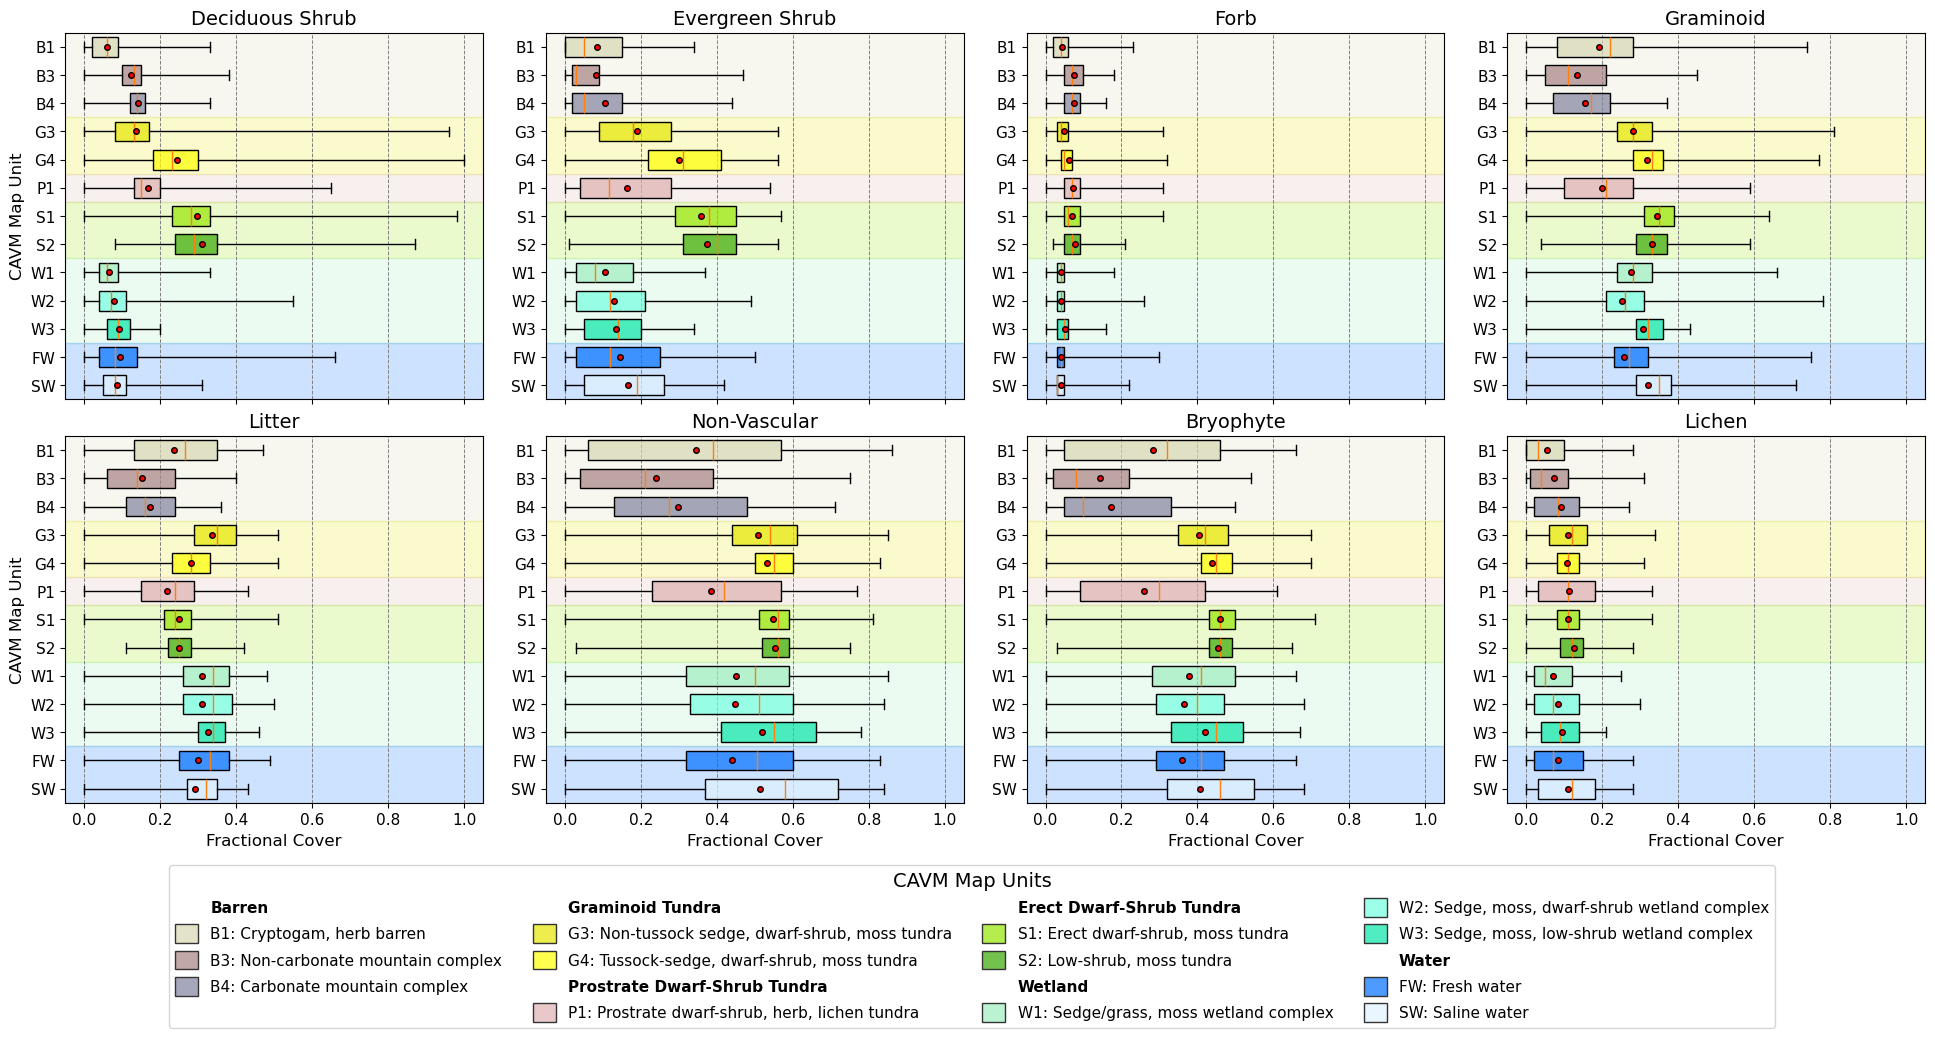

In [6]:
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# Define file paths for each plant functional type (PFT)
pft_files = {
    'deciduous_shrub_cover': "zonal_stats_20250303/deciduous_shrub_masked_mac.txt",
    'evergreen_shrub_cover': "zonal_stats_20250303/evergreen_shrub_masked_mac.txt",
    'forb_cover': "zonal_stats_20250303/forb_masked_mac.txt",
    'graminoid_cover': "zonal_stats_20250303/graminoid_masked_mac.txt",
    'litter_cover': "zonal_stats_20250303/litter_masked_mac.txt",
    'lichen_cover': "zonal_stats_20250303/lichen_masked_mac.txt",
    'bryophyte_cover': "zonal_stats_20250303/bryophyte_masked_mac.txt",
    'non-vascular_cover': "zonal_stats_20250303/non-vascular_masked_mac.txt"
}

# Create mapping of zone numbers to CAVM unit names
zone_to_cavm = {entry['value']: entry['label'] for entry in palette_entries}
print(zone_to_cavm)

# Ensure we work with a copy of legend_df to avoid modifying the original
legend_df_copy = legend_df[['Vegetation Unit', 'Short Description']].drop_duplicates().copy()

# Identify all possible zones across all datasets
all_zones = set()

# First pass: Collect all unique zones
for file_path in pft_files.values():
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, usecols=['zone'])
        all_zones.update(df['zone'].astype(str).dropna().unique())

all_zones = sorted(all_zones)  # Sort for consistent ordering

# Define the desired subplot order
plot_order = [
    'deciduous_shrub_cover', 'evergreen_shrub_cover', 'forb_cover', 'graminoid_cover',
    'litter_cover', 'non-vascular_cover', 'bryophyte_cover', 'lichen_cover'
]

# Second pass: Process each dataset and ensure all zones are included
precomputed_boxplot_data = {}
for cover_type, file_path in pft_files.items():
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)

        # Drop NaN values and ensure necessary columns exist
        df = df[['zone', 'min', 'first_quart', 'median', 'third_quart', 'max', 'mean']]

        # Convert 'zone' to string and map to CAVM unit names
        df['zone'] = df['zone'].astype(str)
        df['CAVM Unit'] = df['zone'].map(zone_to_cavm)

        # Ensure all zones are present, filling missing ones with NaN
        df = df.set_index('zone').reindex(all_zones).reset_index()

        # Map CAVM Unit again after reindexing
        df['CAVM Unit'] = df['zone'].map(zone_to_cavm)
        df = df.dropna(subset=['CAVM Unit'])
        df = df[df['CAVM Unit'] != 'NA']  # Drop 'NA' CAVM Unit

        # Merge with legend_df_copy to add Short Description as cavm_unit_description
        df = df.merge(legend_df_copy, left_on='CAVM Unit', right_on='Vegetation Unit', how='left')
        df = df.rename(columns={'Short Description': 'cavm_unit_description'})

        df['Cover Type'] = cover_type  # Label with cover type
        precomputed_boxplot_data[cover_type] = df

# Identify zones where all datasets have only NaNs
all_dfs = [df.set_index('zone')[['min', 'first_quart', 'median', 'third_quart', 'max', 'mean']] for df in precomputed_boxplot_data.values()]
combined_df = pd.concat(all_dfs, axis=1, keys=precomputed_boxplot_data.keys())  # MultiIndex column structure
nan_only_zones = combined_df.isna().all(axis=1)  # Identify zones that are NaN across all datasets
zones_to_remove = nan_only_zones[nan_only_zones].index.tolist()  # Get list of zones to drop

# Remove those zones from all datasets
for cover_type in precomputed_boxplot_data:
    precomputed_boxplot_data[cover_type] = precomputed_boxplot_data[cover_type][~precomputed_boxplot_data[cover_type]['zone'].isin(zones_to_remove)]

# Define the color map from palette_entries
color_map = {entry['label']: (mcolors.hex2color(entry['color']) + (int(entry['alpha']) / 255,)) for entry in palette_entries}

# Define order of CAVM units based on the given mapping
cavm_order = [entry['label'] for entry in palette_entries]

# Ensure plots are arranged in the specified order
ordered_boxplot_data = {cover_type: precomputed_boxplot_data[cover_type] for cover_type in plot_order if cover_type in precomputed_boxplot_data}

# Set up the subplots
num_cols = 4
num_rows = 2  # Fixed to match the two-row layout
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(24, 10), sharex=True)
axes = axes.flatten()

# Create boxplots using precomputed stats
for i, (ax, cover_type) in enumerate(zip(axes, ordered_boxplot_data.keys())):
    
    data = ordered_boxplot_data[cover_type]
    title = cover_type.replace('_', ' ').replace(' cover', '').title()

    # Ensure category order for y-axis
    data['CAVM Unit'] = pd.Categorical(data['CAVM Unit'], categories=cavm_order, ordered=True)
    data = data.sort_values('CAVM Unit')

    # Prepare boxplot statistics
    bxp_stats = []
    y_labels = []
    for _, row in data.iterrows():
        y_labels.append(row['CAVM Unit'])
        bxp_stats.append({
            'med': row['median'] / 100,
            'q1': row['first_quart'] / 100,
            'q3': row['third_quart'] / 100,
            'whislo': row['min'] / 100,
            'whishi': row['max'] / 100,
            'mean': row['mean'] / 100,
            'fliers': []  # No outliers in dataset
        })

    # Plot boxplots using precomputed statistics (flipped orientation)
    artist = ax.bxp(bxp_stats,
                    vert=False,  # Flip the boxplots horizontally
                    showmeans=True,
                    meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'black', 'markersize':'4'},
                    patch_artist=True,
                    widths=0.7)

    # Color boxes based on the vegetation unit
    for patch, cavm_unit in zip(artist['boxes'], y_labels):
        patch.set_facecolor(color_map.get(cavm_unit, 'gray'))  # Default to gray if color not found

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Fractional Cover', fontsize=12)
    ax.set_yticklabels(y_labels)
    ax.set_xlim(-0.05,1.05)
    
    if i % num_cols == 0:
        ax.set_ylabel('CAVM Map Unit', fontsize=12)
    else:
        ax.set_ylabel('')
    
    ax.xaxis.grid(True, linestyle='--', linewidth=0.8, color='grey')
    ax.invert_yaxis()

    # Define shading regions
    fill_regions = [('B1', 'G3'),
                    ('G3', 'P1'),
                    ('P1', 'S1'),
                    ('S1', 'W1'),
                    ('W1', 'FW'),
                    ('FW', 'SW')]

    # Apply region shading
    for start_unit, end_unit in fill_regions:
        if start_unit in y_labels and end_unit in y_labels:
            start_index = y_labels.index(start_unit) + 0.5
            end_index = y_labels.index(end_unit) + 0.5
    
            # Ensure shading extends fully to the bottom of the graph
            if end_unit == y_labels[-1]:  
                end_index = len(y_labels) + 0.5  # Extend to the very bottom
    
            color = color_map[start_unit]
            ax.axhspan(
                ymin=end_index, ymax=start_index,
                color=color,
                alpha=0.2
            )

    # Only label bottom row subplots
    if i >= num_cols:
        ax.set_xlabel('Fractional Cover', fontsize=12)
    else:
        ax.set_xlabel('')

    ax.xaxis.grid(True, linestyle='--', linewidth=0.7, color='grey')
    ax.tick_params(axis='both', which='major', labelsize=11)

# Create the legend handles with adjusted column distribution
sections = {
    'Barren': ['B1', 'B3', 'B4'],
    'Graminoid Tundra': ['G3', 'G4'],
    'Prostrate Dwarf-Shrub Tundra': ['P1'],
    'Erect Dwarf-Shrub Tundra': ['S1', 'S2'],
    'Wetland': ['W1', 'W2', 'W3'],
    'Water': ['FW', 'SW']
}

# Create legend handles and their corresponding labels
handles = []
for section, units in sections.items():
    handles.append(mpatches.Patch(facecolor='none', edgecolor='none', label=f'{section}'))
    
    for unit in units:
        unit_description = legend_df_copy.loc[legend_df_copy['Vegetation Unit'] == unit, 'Short Description']
        description = unit_description.values[0] if not unit_description.empty else "Description not available"
        
        handles.append(
            mpatches.Patch(
                facecolor=color_map[unit],  
                label=f"{unit}: {description}",
                edgecolor='#333333', 
                linewidth=1  
            )
        )

    # Add dummy patches to align legend items in columns
    if section == 'Barren':  # Needs 1 dummy item
        handles.append(mpatches.Patch(facecolor='none', edgecolor='none', label=' '))

plt.legend(
    handles=handles,
    title='CAVM Map Units',
    bbox_to_anchor=(-1.28, -0.15),
    loc='upper center',
    ncol=4,
    fontsize=11,
    title_fontsize=14,
    handlelength=1.5,
    handleheight=1.5
)

# Customize the section titles to be bold
for label in plt.gca().get_legend().get_texts():
    if label.get_text() in sections:  # Check if the label is a section title
        label.set_fontweight('bold')  # Set the section title to bold

# Hide any unused axes
for i in range(len(ordered_boxplot_data), len(axes)):
    axes[i].axis('off')

# Adjust spacing
plt.subplots_adjust(hspace=0.1, wspace=0.15)
plt.tight_layout()
plt.show()

# PAVC-Gridded (clipped/masked) and CAVM overlap

{'1': 'B1', '2': 'B2a', '3': 'B3', '4': 'B4', '5': 'B2b', '21': 'G1', '22': 'G2', '23': 'G3', '24': 'G4', '31': 'P1', '32': 'P2', '33': 'S1', '34': 'S2', '41': 'W1', '42': 'W2', '43': 'W3', '91': 'FW', '92': 'SW', '93': 'GL', '99': 'NA'}


/tmp/ipykernel_446626/3290032493.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CAVM Unit'] = pd.Categorical(data['CAVM Unit'], categories=cavm_order, ordered=True)
/tmp/ipykernel_446626/3290032493.py:228: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


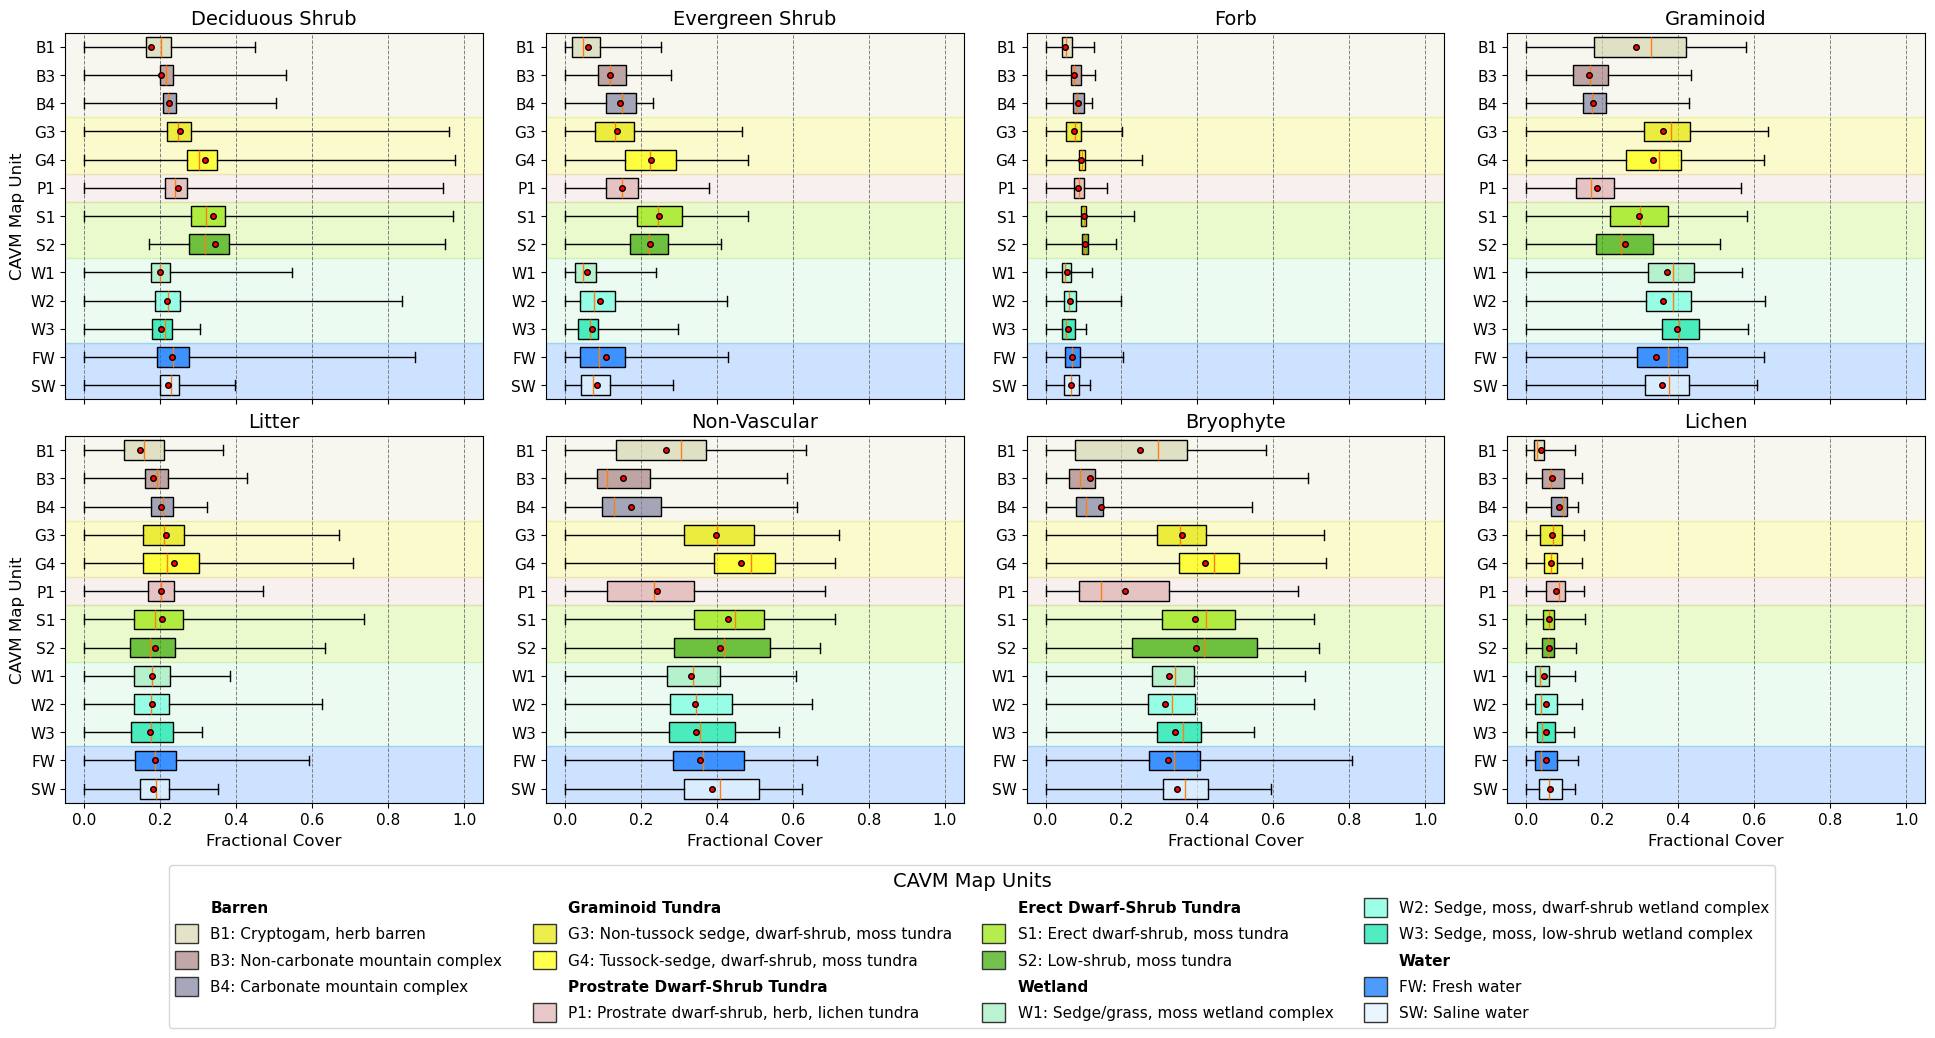

In [7]:
# Define file paths for each plant functional type (PFT)
pft_files = {
    'deciduous_shrub_cover': "zonal_stats_20250303/deciduous_shrub_masked_macclip.txt",
    'evergreen_shrub_cover': "zonal_stats_20250303/evergreen_shrub_masked_macclip.txt",
    'forb_cover': "zonal_stats_20250303/forb_masked_macclip.txt",
    'graminoid_cover': "zonal_stats_20250303/graminoid_masked_macclip.txt",
    'litter_cover': "zonal_stats_20250303/litter_masked_macclip.txt",
    'lichen_cover': "zonal_stats_20250303/lichen_masked_macclip.txt",
    'bryophyte_cover': "zonal_stats_20250303/bryophyte_masked_macclip.txt",
    'non-vascular_cover': "zonal_stats_20250303/non-vascular_masked_macclip.txt"
}

# Create mapping of zone numbers to CAVM unit names
zone_to_cavm = {entry['value']: entry['label'] for entry in palette_entries}
print(zone_to_cavm)

# Ensure we work with a copy of legend_df to avoid modifying the original
legend_df_copy = legend_df[['Vegetation Unit', 'Short Description']].drop_duplicates().copy()

# Identify all possible zones across all datasets
all_zones = set()

# First pass: Collect all unique zones
for file_path in pft_files.values():
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, usecols=['zone'])
        all_zones.update(df['zone'].astype(str).dropna().unique())

all_zones = sorted(all_zones)  # Sort for consistent ordering

# Define the desired subplot order
plot_order = [
    'deciduous_shrub_cover', 'evergreen_shrub_cover', 'forb_cover', 'graminoid_cover',
    'litter_cover', 'non-vascular_cover', 'bryophyte_cover', 'lichen_cover'
]

# Second pass: Process each dataset and ensure all zones are included
precomputed_boxplot_data = {}
for cover_type, file_path in pft_files.items():
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)

        # Drop NaN values and ensure necessary columns exist
        df = df[['zone', 'min', 'first_quart', 'median', 'third_quart', 'max', 'mean']]

        # Convert 'zone' to string and map to CAVM unit names
        df['zone'] = df['zone'].astype(str)
        df['CAVM Unit'] = df['zone'].map(zone_to_cavm)

        # Ensure all zones are present, filling missing ones with NaN
        df = df.set_index('zone').reindex(all_zones).reset_index()

        # Map CAVM Unit again after reindexing
        df['CAVM Unit'] = df['zone'].map(zone_to_cavm)
        df = df.dropna(subset=['CAVM Unit'])
        df = df[df['CAVM Unit'] != 'NA']  # Drop 'NA' CAVM Unit

        # Merge with legend_df_copy to add Short Description as cavm_unit_description
        df = df.merge(legend_df_copy, left_on='CAVM Unit', right_on='Vegetation Unit', how='left')
        df = df.rename(columns={'Short Description': 'cavm_unit_description'})

        df['Cover Type'] = cover_type  # Label with cover type
        precomputed_boxplot_data[cover_type] = df

# Identify zones where all datasets have only NaNs
all_dfs = [df.set_index('zone')[['min', 'first_quart', 'median', 'third_quart', 'max', 'mean']] for df in precomputed_boxplot_data.values()]
combined_df = pd.concat(all_dfs, axis=1, keys=precomputed_boxplot_data.keys())  # MultiIndex column structure
nan_only_zones = combined_df.isna().all(axis=1)  # Identify zones that are NaN across all datasets
zones_to_remove = nan_only_zones[nan_only_zones].index.tolist()  # Get list of zones to drop

# Remove those zones from all datasets
for cover_type in precomputed_boxplot_data:
    precomputed_boxplot_data[cover_type] = precomputed_boxplot_data[cover_type][~precomputed_boxplot_data[cover_type]['zone'].isin(zones_to_remove)]

# Define the color map from palette_entries
color_map = {entry['label']: (mcolors.hex2color(entry['color']) + (int(entry['alpha']) / 255,)) for entry in palette_entries}

# Define order of CAVM units based on the given mapping
cavm_order = [entry['label'] for entry in palette_entries]

# Ensure plots are arranged in the specified order
ordered_boxplot_data = {cover_type: precomputed_boxplot_data[cover_type] for cover_type in plot_order if cover_type in precomputed_boxplot_data}

# Set up the subplots
num_cols = 4
num_units = len(precomputed_boxplot_data)
num_rows = int(np.ceil(num_units / num_cols))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(24, 10), sharex=True)
axes = axes.flatten()

# Create boxplots using precomputed stats
for i, (ax, cover_type) in enumerate(zip(axes, ordered_boxplot_data.keys())):
    
    data = ordered_boxplot_data[cover_type]
    title = cover_type.replace('_', ' ').replace(' cover', '').title()

    # Ensure category order for y-axis
    data['CAVM Unit'] = pd.Categorical(data['CAVM Unit'], categories=cavm_order, ordered=True)
    data = data.sort_values('CAVM Unit')

    # Prepare boxplot statistics
    bxp_stats = []
    y_labels = []
    for _, row in data.iterrows():
        y_labels.append(row['CAVM Unit'])
        bxp_stats.append({
            'med': row['median'],
            'q1': row['first_quart'],
            'q3': row['third_quart'],
            'whislo': row['min'],
            'whishi': row['max'],
            'mean': row['mean'],
            'fliers': []  # No outliers in dataset
        })

    # Plot boxplots using precomputed statistics (flipped orientation)
    artist = ax.bxp(bxp_stats,
                    vert=False,  # Flip the boxplots horizontally
                    showmeans=True,
                    meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'black', 'markersize':'4'},
                    patch_artist=True,
                    widths=0.7)

    # Color boxes based on the vegetation unit
    for patch, cavm_unit in zip(artist['boxes'], y_labels):
        patch.set_facecolor(color_map.get(cavm_unit, 'gray'))  # Default to gray if color not found

    ax.set_title(title, fontsize=14)
    ax.set_yticklabels(y_labels)
    ax.set_xlim(-0.05,1.05)
    
    # Only label bottom row subplots
    if i % num_cols == 0:
        ax.set_ylabel('CAVM Map Unit', fontsize=12)
    else:
        ax.set_ylabel('')

    # Define shading regions
    fill_regions = [('B1', 'G3'),
                    ('G3', 'P1'),
                    ('P1', 'S1'),
                    ('S1', 'W1'),
                    ('W1', 'FW'),
                    ('FW', 'SW')]

    # Apply region shading
    for start_unit, end_unit in fill_regions:
        if start_unit in y_labels and end_unit in y_labels:
            start_index = y_labels.index(start_unit) + 0.5
            end_index = y_labels.index(end_unit) + 0.5
    
            # Ensure shading extends fully to the bottom of the graph
            if end_unit == y_labels[-1]:  
                end_index = len(y_labels) + 0.5  # Extend to the very bottom
    
            color = color_map[start_unit]
            ax.axhspan(
                ymin=end_index, ymax=start_index,
                color=color,
                alpha=0.2
            )

    # Only label bottom row subplots
    if i >= num_cols:
        ax.set_xlabel('Fractional Cover', fontsize=12)
    else:
        ax.set_xlabel('')

    ax.xaxis.grid(True, linestyle='--', linewidth=0.7, color='grey')
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.invert_yaxis()

sections = {
    'Barren': ['B1', 'B3', 'B4'],
    'Graminoid Tundra': ['G3', 'G4'],
    'Prostrate Dwarf-Shrub Tundra': ['P1'],
    'Erect Dwarf-Shrub Tundra': ['S1', 'S2'],
    'Wetland': ['W1', 'W2', 'W3'],
    'Water': ['FW', 'SW']
}

# Create legend handles and their corresponding labels
handles = []
for section, units in sections.items():
    handles.append(mpatches.Patch(facecolor='none', edgecolor='none', label=f'{section}'))
    
    for unit in units:
        unit_description = legend_df_copy.loc[legend_df_copy['Vegetation Unit'] == unit, 'Short Description']
        description = unit_description.values[0] if not unit_description.empty else "Description not available"
        
        handles.append(
            mpatches.Patch(
                facecolor=color_map[unit],  
                label=f"{unit}: {description}",
                edgecolor='#333333', 
                linewidth=1  
            )
        )

    # Add dummy patches to align legend items in columns
    if section == 'Barren':  # Needs 1 dummy item
        handles.append(mpatches.Patch(facecolor='none', edgecolor='none', label=' '))

plt.legend(
    handles=handles,
    title='CAVM Map Units',
    bbox_to_anchor=(-1.28, -0.15),
    loc='upper center',
    ncol=4,
    fontsize=11,
    title_fontsize=14,
    handlelength=1.5,
    handleheight=1.5
)

# Customize the section titles to be bold
for label in plt.gca().get_legend().get_texts():
    if label.get_text() in sections:  # Check if the label is a section title
        label.set_fontweight('bold')  # Set the section title to bold

# Hide any unused axes
for i in range(len(ordered_boxplot_data), len(axes)):
    axes[i].axis('off')

# Adjust spacing
plt.subplots_adjust(hspace=0.1, wspace=0.15)
plt.tight_layout()
plt.show()